# NBA 1990-1991 Season Analysis

# Imports

In [12]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



import psycopg2
from dotenv import load_dotenv

from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score


# Models

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Constants

In [4]:
dotenv_path = ("/Users/maukanmir/Documents/Machine-Learning/NBA Projects/1990-1991-Season-Analysis/dot.env")
load_dotenv(dotenv_path)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
TABLE_NAME = "salaries_and_stats"

In [54]:
conn = psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    port=DB_PORT
)

query = f"SELECT * FROM {TABLE_NAME} where season = '1990-1991';"
df = pd.read_sql_query(query, conn)

conn.close()

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [10]:
df

,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,3PM,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,2500000.0,Michael Jordan,CHI,82,37.0,31.5,12.1,22.4,0.539,0.4,...,8.2,0.851,1.4,4.6,6.0,5.5,2.7,1.0,2.5,1990-1991
1,2260000.0,Karl Malone,UTA,82,40.3,29.0,10.3,19.6,0.527,0.0,...,10.8,0.770,2.9,8.9,11.8,3.3,1.1,1.0,3.0,1990-1991
2,1600000.0,Bernard King,WAS,64,37.5,28.4,11.1,23.6,0.472,0.1,...,7.6,0.790,1.8,3.2,5.0,4.6,0.9,0.3,4.0,1990-1991
3,2900000.0,Charles Barkley,PHI,67,37.3,27.6,9.9,17.4,0.570,0.7,...,9.8,0.722,3.9,6.3,10.1,4.2,1.6,0.5,3.1,1990-1991
4,4250000.0,Patrick Ewing,NYK,81,38.3,26.6,10.4,20.3,0.514,0.0,...,7.7,0.745,2.4,8.8,11.2,3.0,1.0,3.2,3.6,1990-1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,550000.0,Larry Drew,LAL,48,10.3,2.9,1.1,2.6,0.432,0.3,...,0.5,0.773,0.1,0.6,0.7,2.5,0.3,0.0,1.0,1990-1991
239,575000.0,Elden Campbell,LAL,52,7.3,2.8,1.1,2.4,0.455,0.0,...,0.9,0.653,0.8,1.1,1.8,0.2,0.2,0.7,0.3,1990-1991
240,150000.0,Scott Williams,CHI,51,6.6,2.5,1.0,2.0,0.510,0.0,...,0.5,0.714,0.8,1.1,1.9,0.3,0.2,0.3,0.5,1990-1991
241,1100000.0,Wayne Cooper,POR,67,11.1,2.2,0.9,2.2,0.393,0.0,...,0.6,0.786,0.8,2.0,2.8,0.3,0.1,0.9,0.3,1990-1991


# Functions

In [96]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def create_sklearn_pipeline(model, kbest=None):
  steps = [
    ("Scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def scatter_plot_visual(df, interested_columns, y):
  
  plt.figure(figsize=(16,16))
  rows = len(interested_columns)
  dims = (rows+4)//3
  for idx, col in enumerate(interested_columns):
    if col == y:
      continue
    plt.subplot(dims, 3, idx+1)
    sns.scatterplot(df, x=y, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def check_distributions(df, interested_columns, type_visual):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    
    plt.subplot(dims, 4, idx+1)
    sns.histplot(data=df[col], kde=True) if type_visual =="hist" else sns.boxplot(df[col])
    plt.title(f"Distribution of {col}")
    plt.ylabel(col)
    plt.xticks(rotation=45)
  
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  return pd.DataFrame(metric_tracker)

def grab_selected_models(names):
    models = {
        "SVR": SVR(),
        "LR": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "DTR": DecisionTreeRegressor(),
        "GBR": GradientBoostingRegressor(),
        "RFR": RandomForestRegressor(),
        "XGB": XGBRegressor(),
        "LASSO": Lasso(),
        "RIDGE": Ridge(),
        "DUMMY": DummyRegressor(strategy="mean")
    }
    
    return [models[model_name] for model_name in names]
    

def get_metrics(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    exp = explained_variance_score(y, predictions)
    
    return [mae, mse, rmse, r2, exp]

def evaluate_model(model, X, y, metric):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
    mae, mse, rmse, r2, exp = get_metrics(y, preds)
    
    return [
        round(np.mean(scores), 3), 
        round(np.var(scores), 3), 
        round(np.std(scores), 3), 
        round(mae, 3), 
        round(mse, 3),
        round(rmse, 3),
        round(r2, 3),
        round(exp, 3)
    ]

def test_selected_models(model_names, models, X, y, scoring_metric, kbest=None):
    metric_tracker = []
    
    for model, model_name in zip(models, model_names):
        pipeline = create_sklearn_pipeline(model, kbest) if kbest else create_sklearn_pipeline(model) 
        scores = evaluate_model(pipeline, X, y, scoring_metric)
        metric_tracker.append({
            "Model": model_name,
            "Mean": scores[0],
            "Var": scores[1],
            "STD": scores[2],
            "MAE": scores[3],
            "MSE": scores[4],
            "RMSE": scores[5],
            "R2": scores[6],
            "Explained Var": scores[7]
        })
    
    return pd.DataFrame(metric_tracker).sort_values(by="MAE", ascending=True)

def test_kbest_columns(X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)

    metric_tracker.append({
            "Model": model_name,
            'K':k,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
    
  return pd.DataFrame(metric_tracker)

def optimization_search(model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)
      
    print(f"The Best Param: {best_params} for Model: {model_name}")
    metric_tracker.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
  
  return pd.DataFrame(metric_tracker).sort_values(by="MAE", ascending=True)

# EDA Analysis

In [14]:
check_for_nulls_dupes(df)

The amount of Null Values: salary    0
Name      0
Team      0
GP        0
MPG       0
PPG       0
FGM       0
FGA       0
FG%       0
3PM       0
3PA       0
3P%       0
FTM       0
FTA       0
FT%       0
ORB       0
DRB       0
RPG       0
APG       0
SPG       0
BPG       0
TOV       0
season    0
dtype: int64
The amount of Duplicated Values 0


In [15]:
df.dtypes

salary    float64
Name       object
Team       object
GP          int64
MPG       float64
PPG       float64
FGM       float64
FGA       float64
FG%       float64
3PM       float64
3PA       float64
3P%       float64
FTM       float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
RPG       float64
APG       float64
SPG       float64
BPG       float64
TOV       float64
season     object
dtype: object

In [16]:
df.describe()

,salary,GP,MPG,PPG,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV
count,2.430000e+02,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,9.614403e+05,74.300412,25.636626,11.393004,4.433333,9.283128,0.473831,0.241975,0.751852,0.203062,2.288066,2.975309,0.751329,1.467901,3.129630,4.600000,2.683128,0.913169,0.564609,1.667078
std,6.637036e+05,7.726489,8.888419,6.244289,2.365349,4.757925,0.044221,0.385865,1.093305,0.153527,1.588668,1.930649,0.096562,0.929875,1.903202,2.718562,2.348589,0.557807,0.629100,0.807702
min,5.000000e+04,48.000000,6.600000,1.900000,0.800000,2.000000,0.373000,0.000000,0.000000,0.000000,0.100000,0.400000,0.240000,0.100000,0.400000,0.600000,0.200000,0.000000,0.000000,0.300000
25%,4.825000e+05,70.000000,17.900000,5.850000,2.400000,5.000000,0.439500,0.000000,0.100000,0.000000,1.100000,1.500000,0.700000,0.750000,1.750000,2.600000,1.100000,0.500000,0.200000,1.000000
50%,8.250000e+05,76.000000,25.900000,10.600000,4.200000,8.600000,0.472000,0.100000,0.300000,0.240000,1.900000,2.600000,0.759000,1.300000,2.700000,3.900000,1.900000,0.800000,0.300000,1.600000
75%,1.265000e+06,81.000000,33.350000,15.750000,6.000000,12.500000,0.499000,0.300000,1.050000,0.333000,3.100000,4.000000,0.819000,2.100000,4.250000,6.350000,3.600000,1.200000,0.700000,2.100000
max,4.250000e+06,82.000000,40.400000,31.500000,12.100000,23.600000,0.647000,2.500000,8.500000,0.667000,8.300000,10.800000,0.963000,4.500000,9.800000,13.800000,14.200000,3.000000,3.900000,4.000000


In [17]:
numeric_cols = df.select_dtypes(include=["float64", "int64"])

<AxesSubplot:>

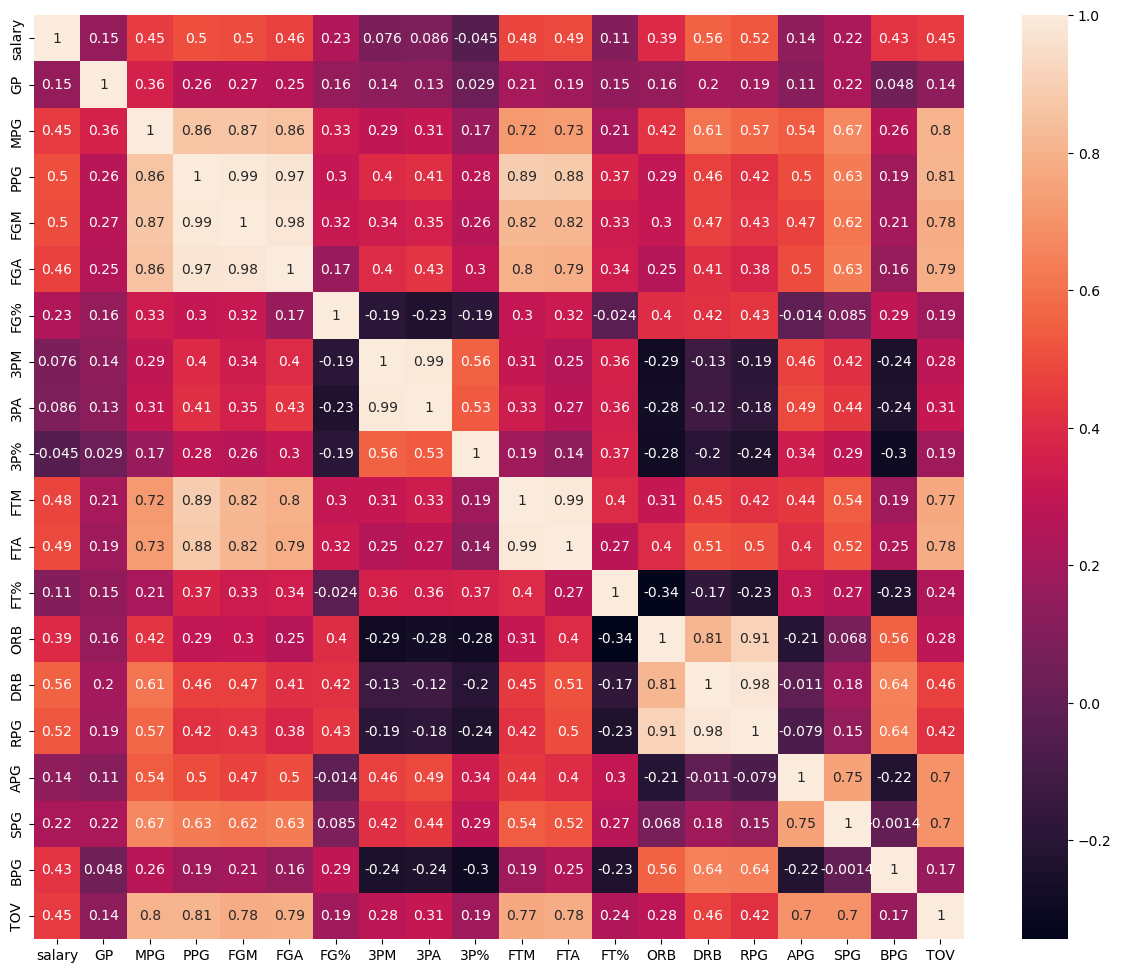

In [18]:
relations = numeric_cols.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(data=relations, annot=True)

# Check Distributions

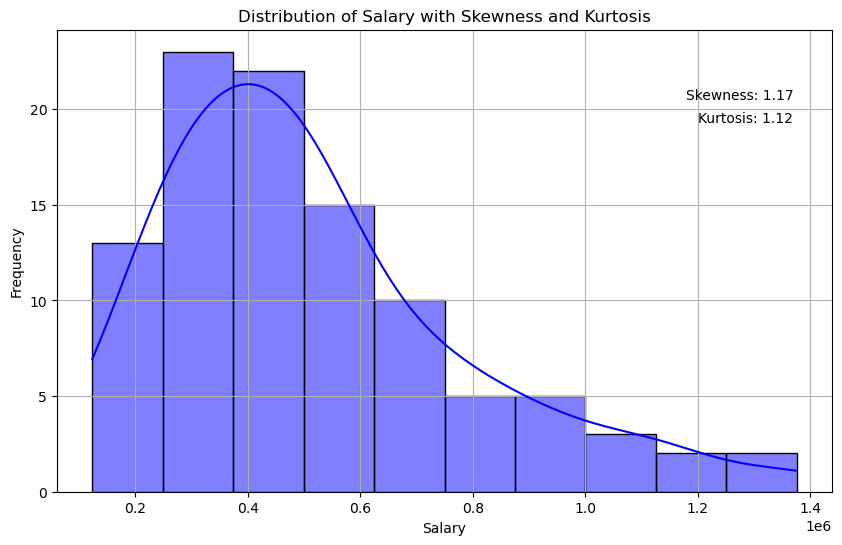

In [27]:
salary_skewness = df['salary'].skew()
salary_kurtosis = df['salary'].kurtosis()

plt.figure(figsize=(10, 6))
sns.histplot(df['salary'], kde=True, color='blue')
plt.title('Distribution of Salary with Skewness and Kurtosis')
plt.xlabel('Salary')
plt.ylabel('Frequency')

plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

plt.grid(True)

plt.show()

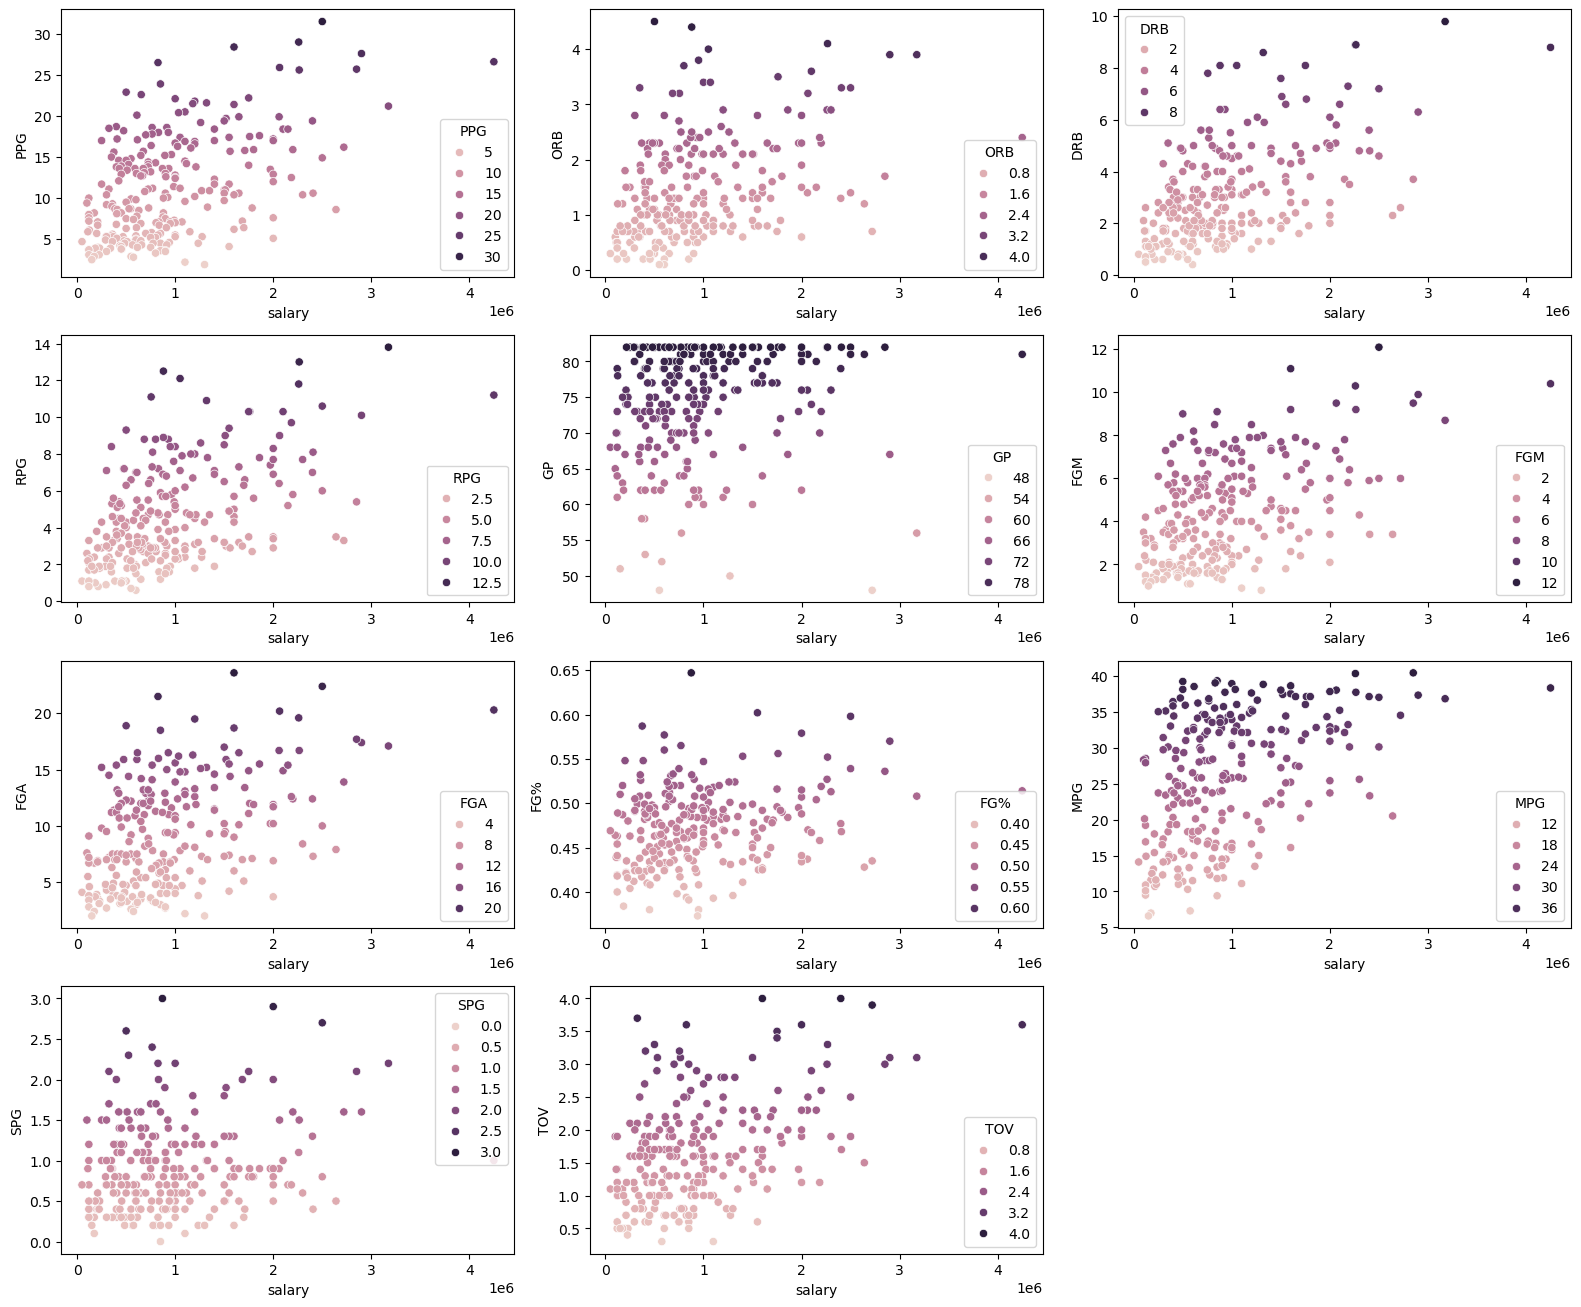

In [42]:
interested_columns = [col for col in numeric_cols.columns if col != "salary"]
scatter_plot_visual(numeric_cols, interested_columns, "salary")

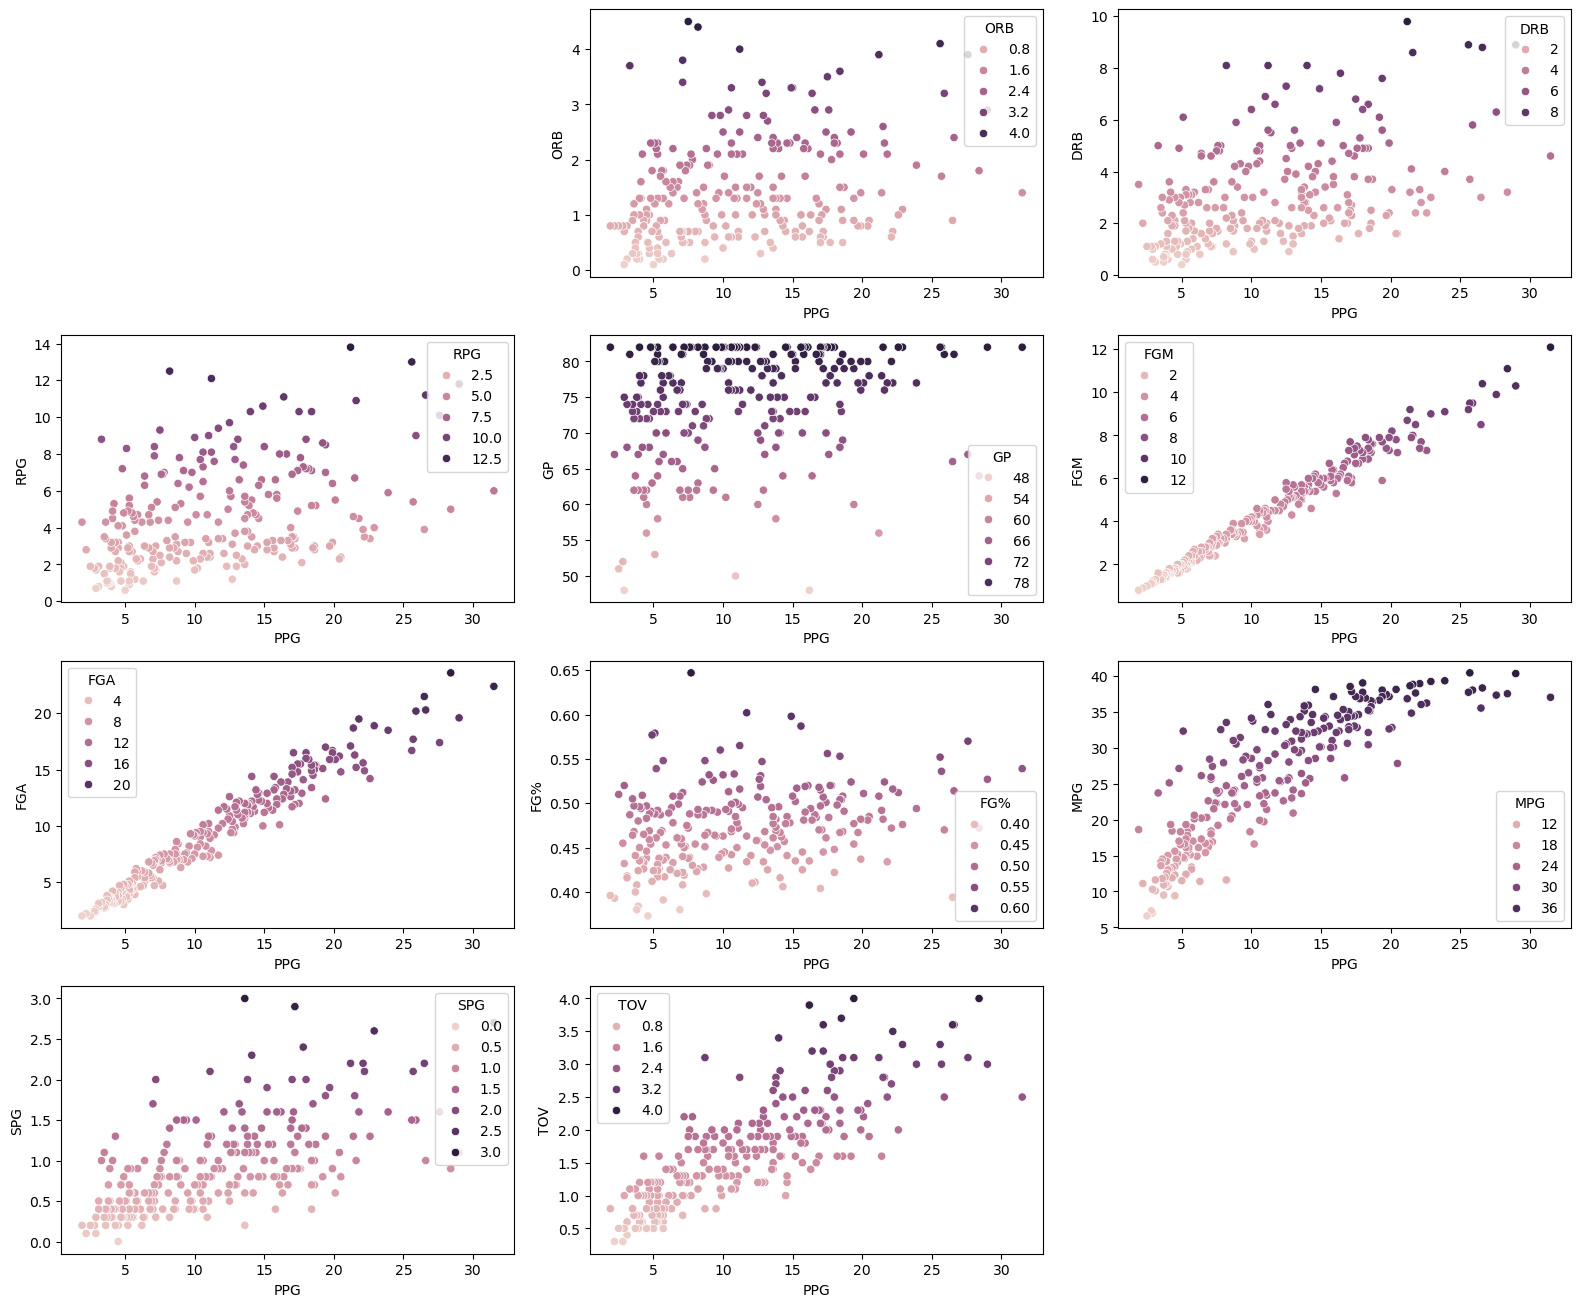

In [43]:
scatter_plot_visual(numeric_cols, interested_columns, "PPG")

# Check Distributions

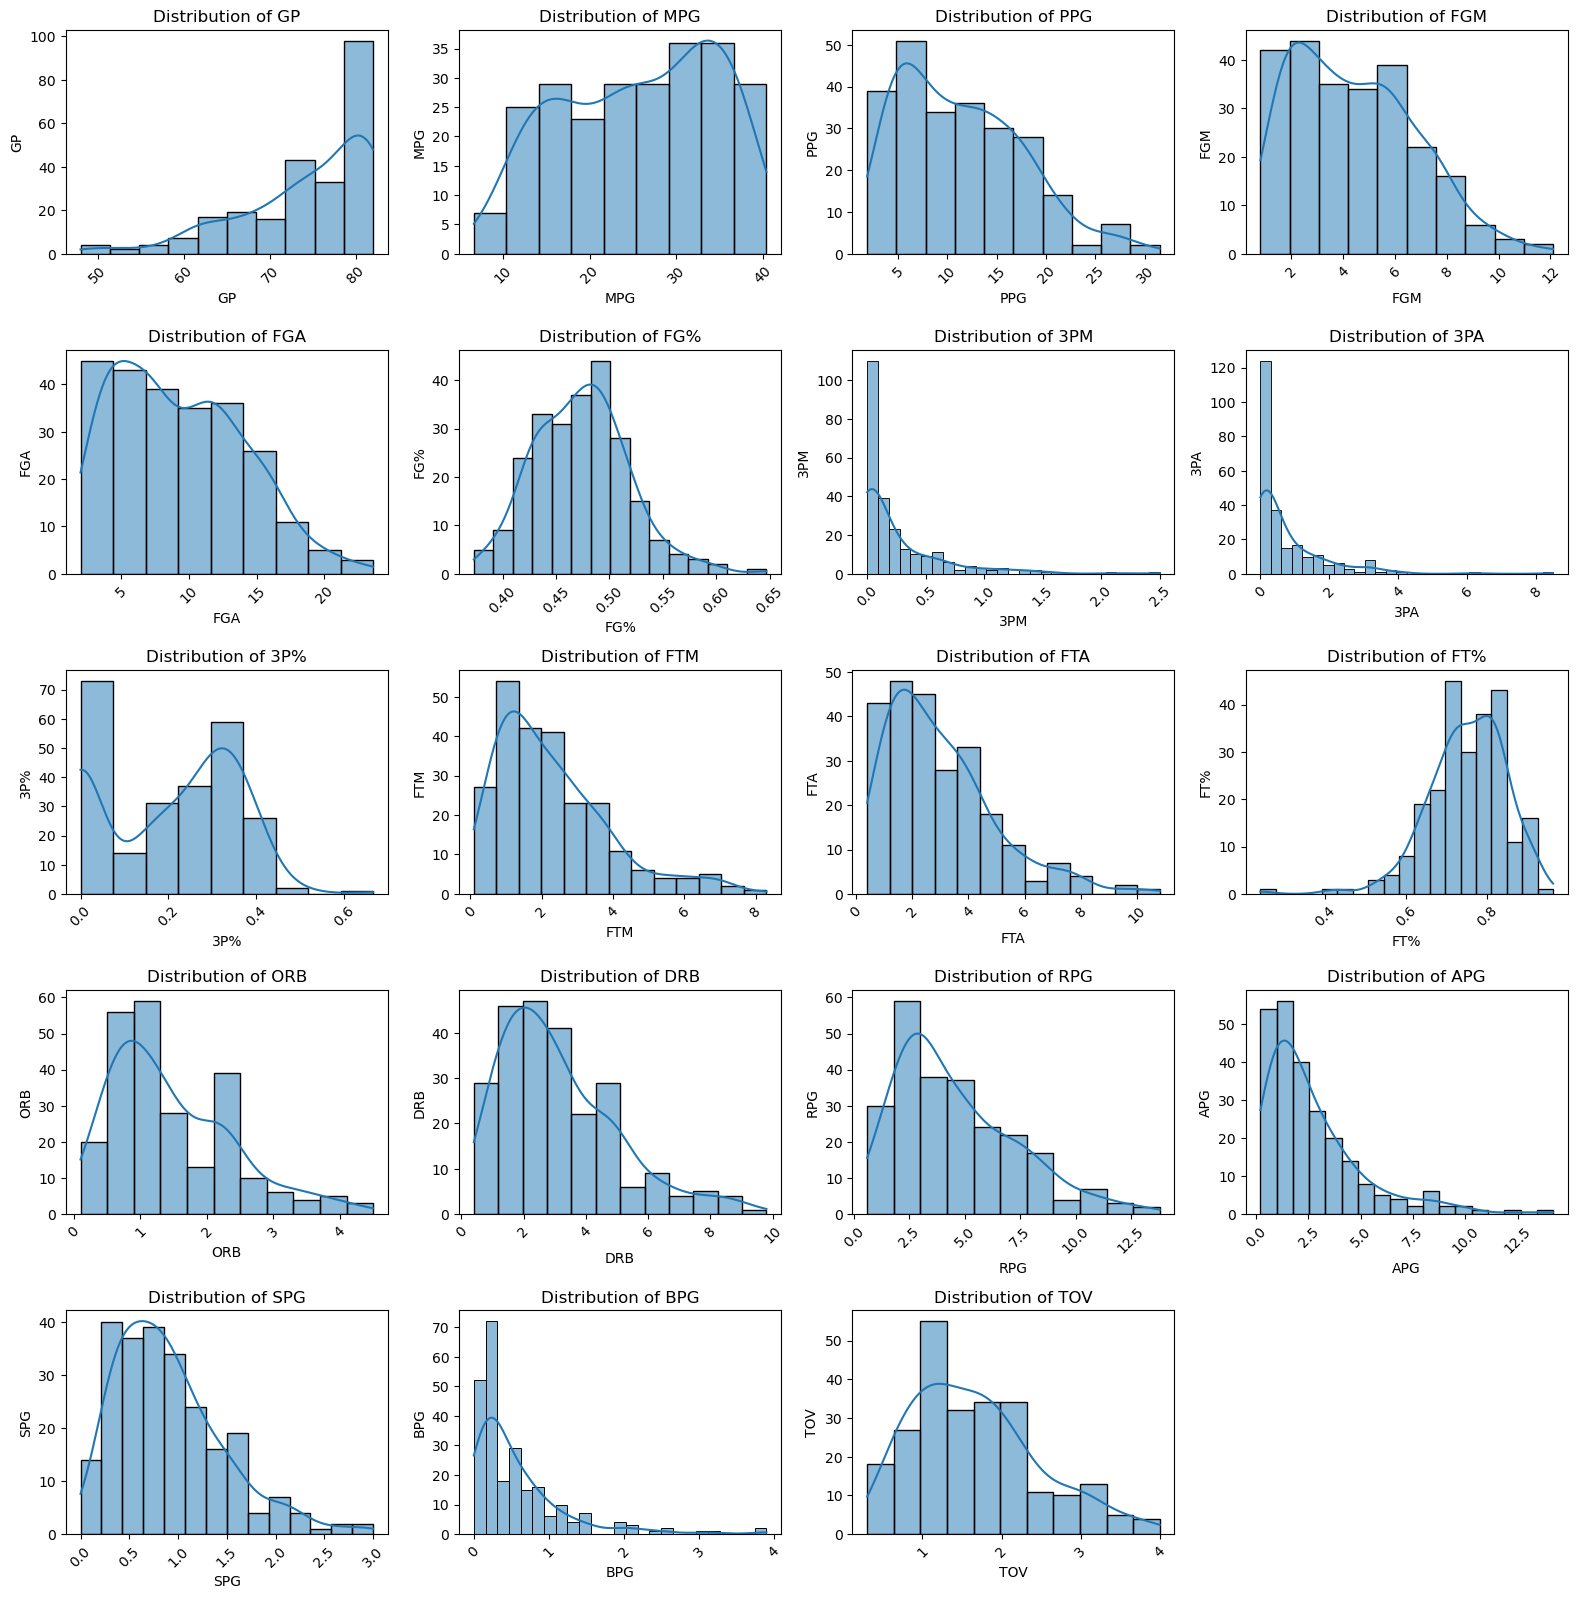

In [50]:
check_distributions(numeric_cols, interested_columns, "hist")

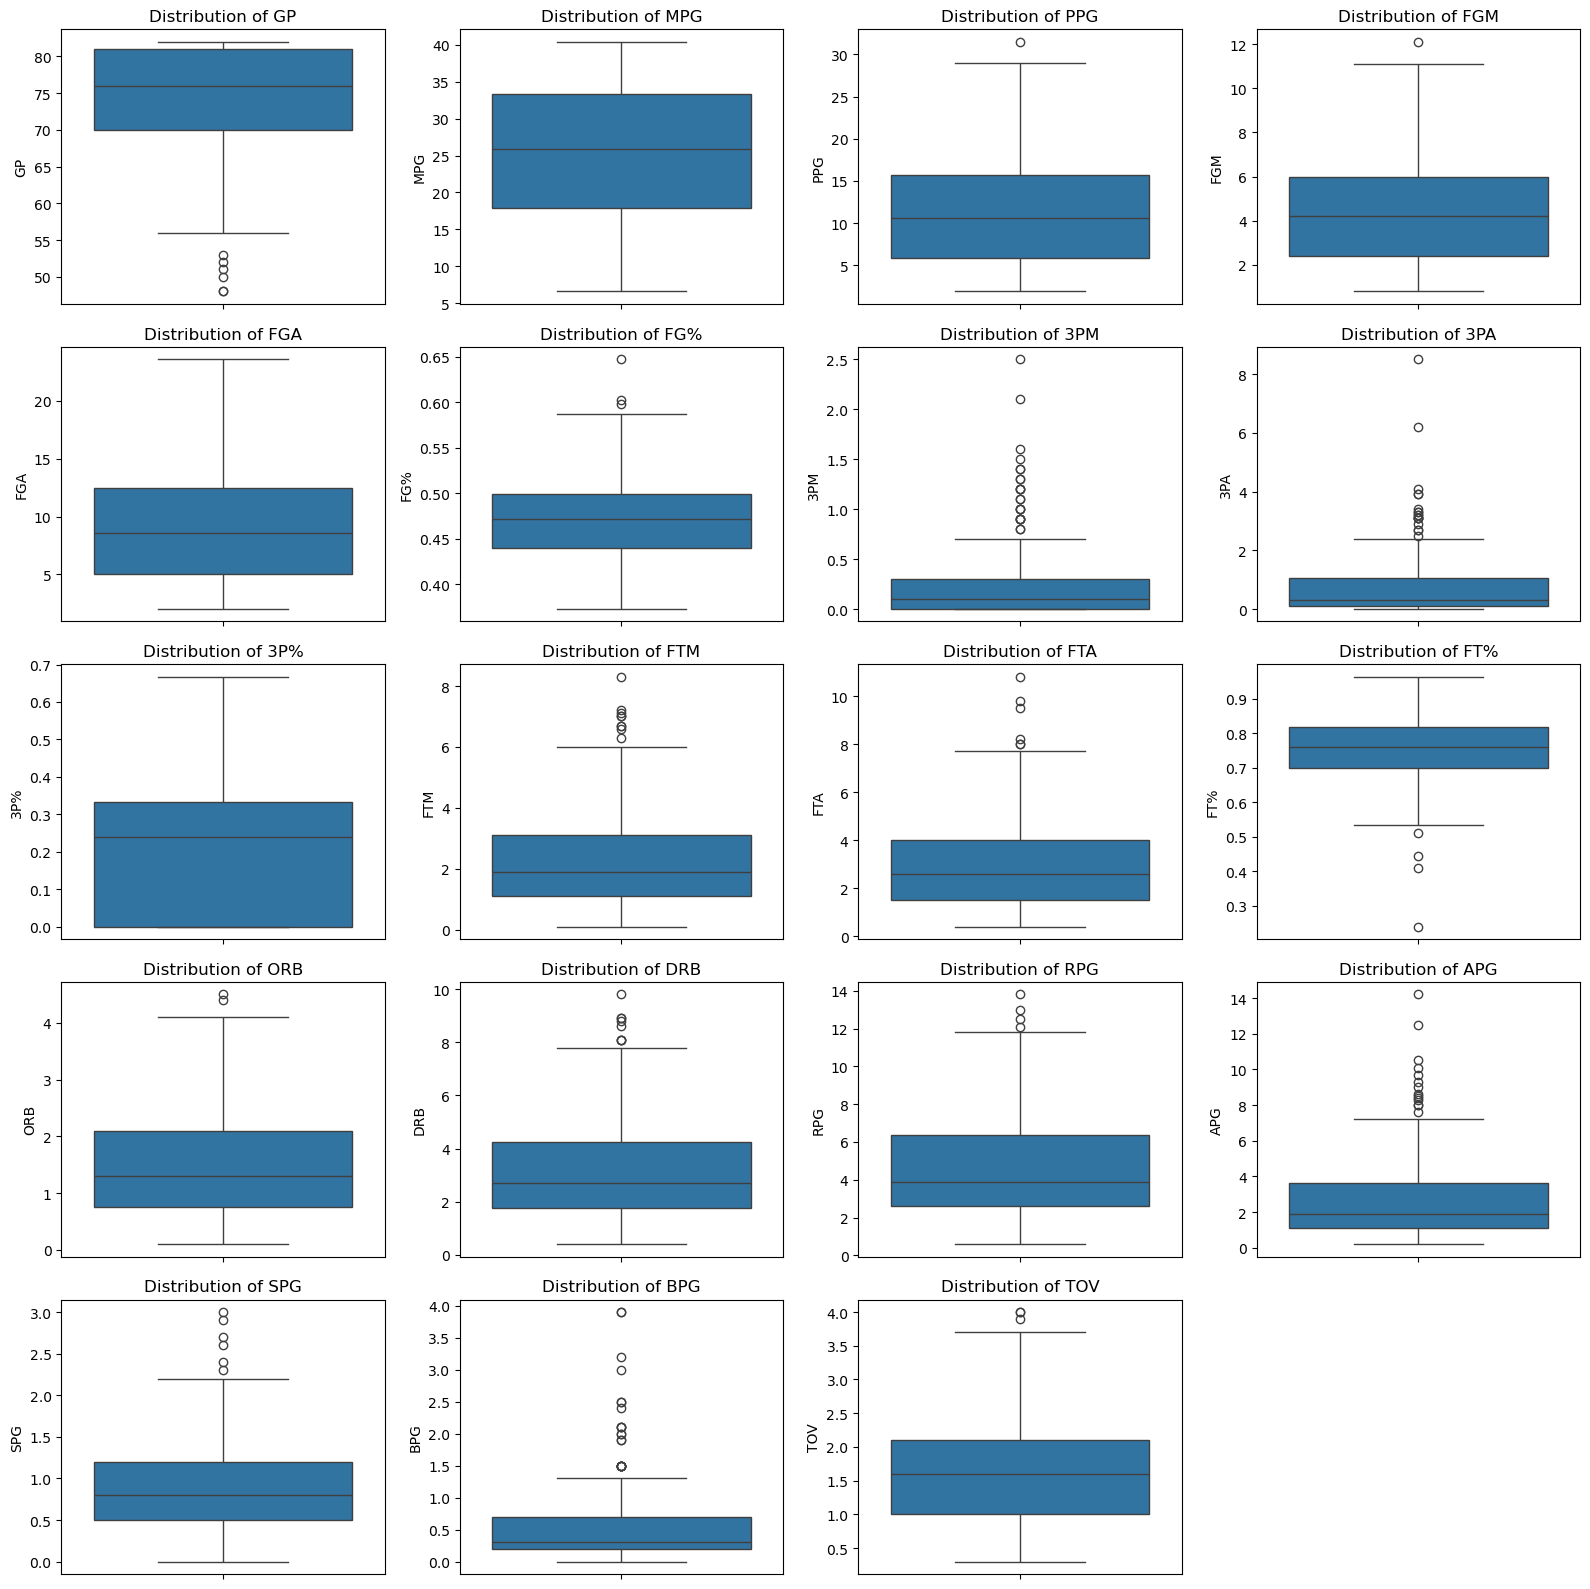

In [51]:
check_distributions(numeric_cols, interested_columns, "boxplot")

# Top 25 Scorers

In [56]:
top_25_scorers = df.sort_values(by="PPG",ascending=False).reset_index().head(25)
top_25_scorers

,index,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,0,2500000.0,Michael Jordan,CHI,82,37.0,31.5,12.1,22.4,0.539,...,8.2,0.851,1.4,4.6,6.0,5.5,2.7,1.0,2.5,1990-1991
1,1,2260000.0,Karl Malone,UTA,82,40.3,29.0,10.3,19.6,0.527,...,10.8,0.770,2.9,8.9,11.8,3.3,1.1,1.0,3.0,1990-1991
2,2,1600000.0,Bernard King,WAS,64,37.5,28.4,11.1,23.6,0.472,...,7.6,0.790,1.8,3.2,5.0,4.6,0.9,0.3,4.0,1990-1991
3,3,2900000.0,Charles Barkley,PHI,67,37.3,27.6,9.9,17.4,0.570,...,9.8,0.722,3.9,6.3,10.1,4.2,1.6,0.5,3.1,1990-1991
4,4,4250000.0,Patrick Ewing,NYK,81,38.3,26.6,10.4,20.3,0.514,...,7.7,0.745,2.4,8.8,11.2,3.0,1.0,3.2,3.6,1990-1991
5,5,825000.0,Michael Adams,DEN,66,35.5,26.5,8.5,21.5,0.394,...,8.0,0.879,0.9,3.0,3.9,10.5,2.2,0.1,3.6,1990-1991
6,6,2065000.0,Dominique Wilkins,ATL,81,38.0,25.9,9.5,20.2,0.470,...,7.1,0.829,3.2,5.8,9.0,3.3,1.5,0.8,2.5,1990-1991
7,7,2850000.0,Chris Mullin,GSW,82,40.4,25.7,9.5,17.7,0.536,...,7.1,0.884,1.7,3.7,5.4,4.0,2.1,0.8,3.0,1990-1991
8,8,2265000.0,David Robinson,SAS,82,37.7,25.6,9.2,16.7,0.552,...,9.5,0.762,4.1,8.9,13.0,2.5,1.5,3.9,3.3,1990-1991
9,9,850000.0,Mitch Richmond,GSW,77,39.3,23.9,9.1,18.5,0.494,...,6.0,0.847,1.9,4.0,5.9,3.1,1.6,0.4,3.0,1990-1991


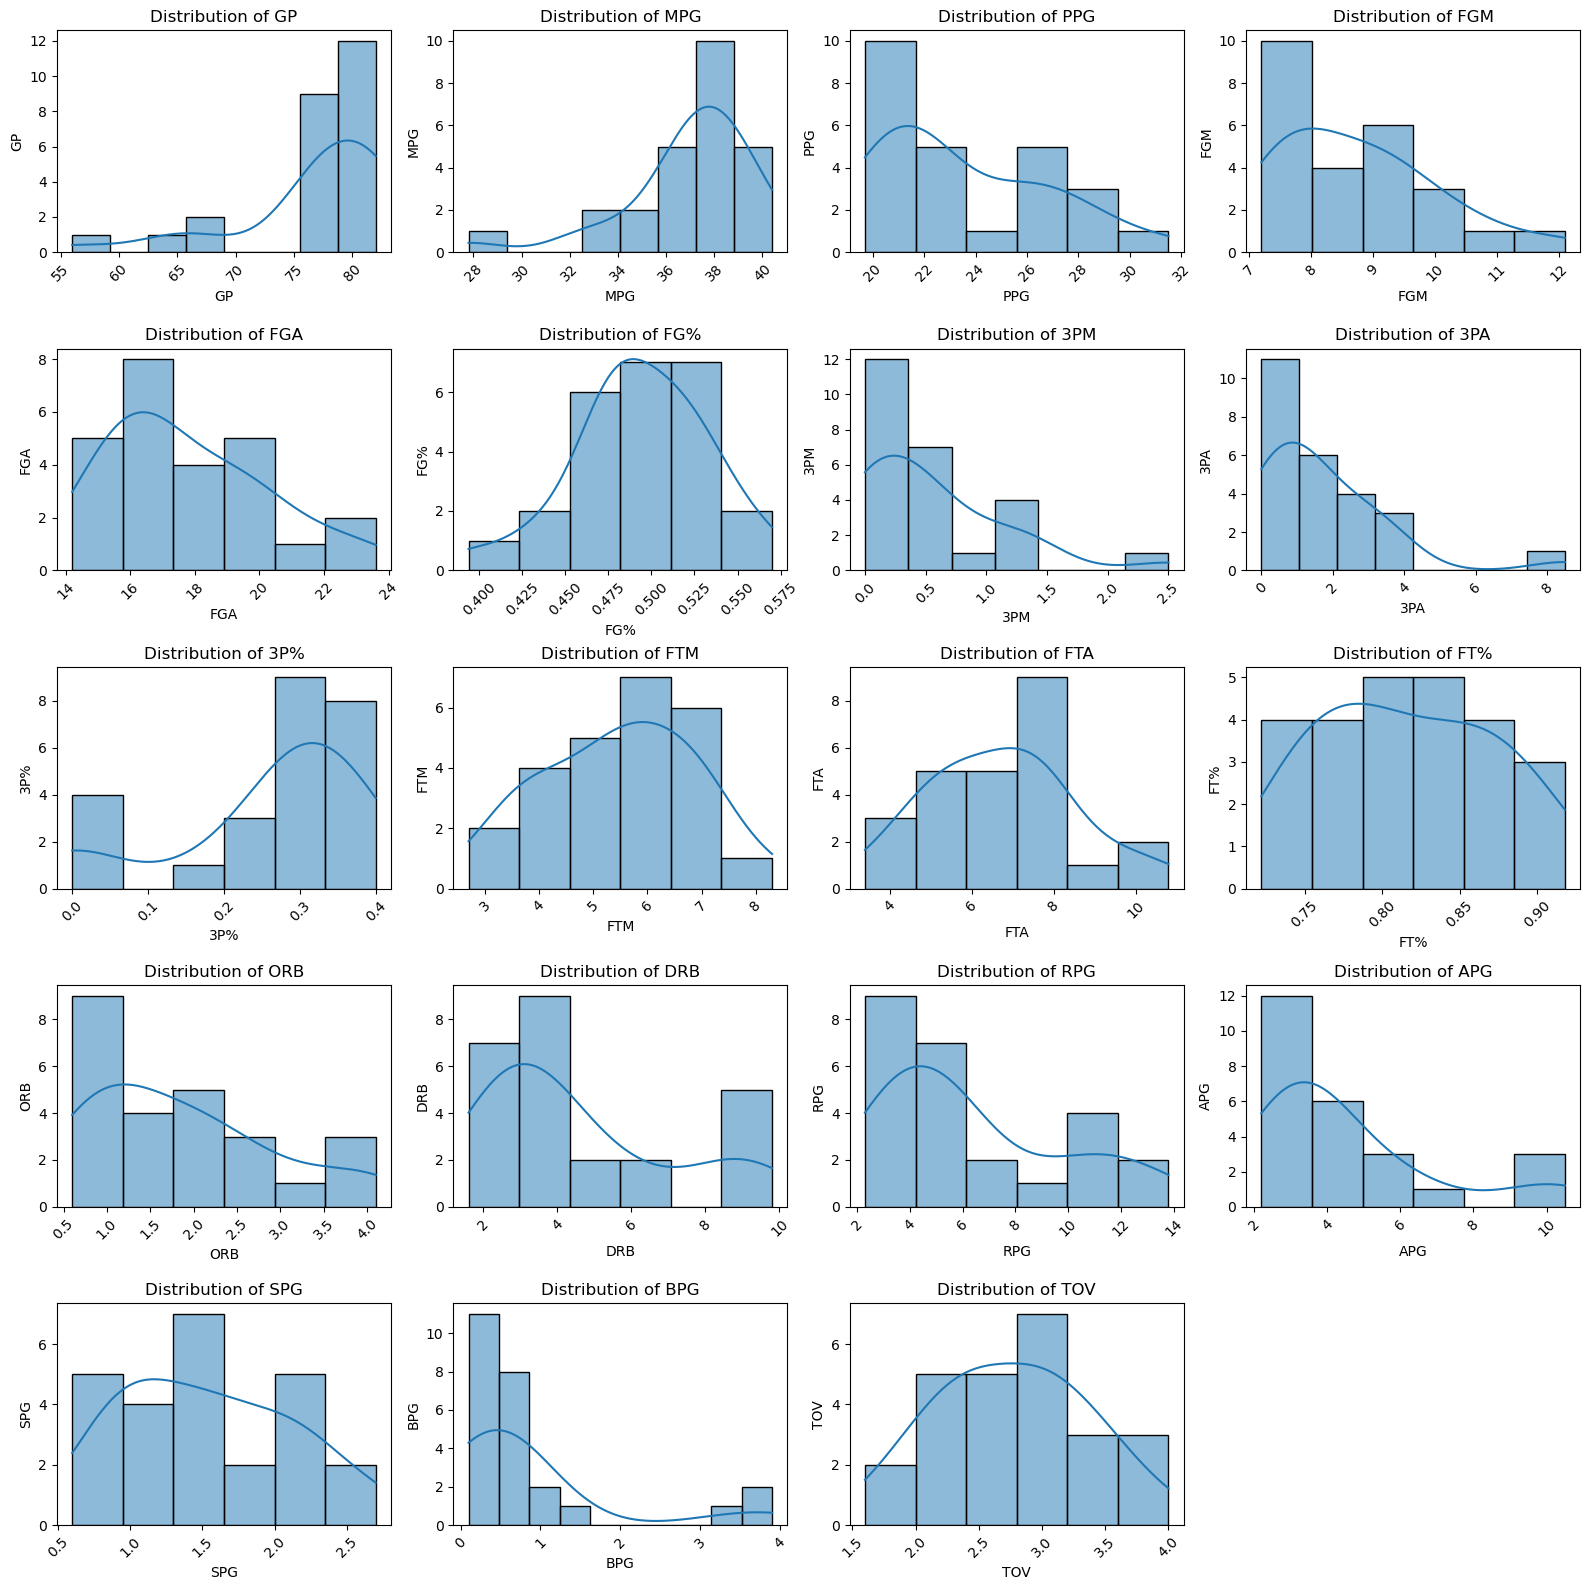

In [57]:
check_distributions(top_25_scorers, interested_columns, "hist")

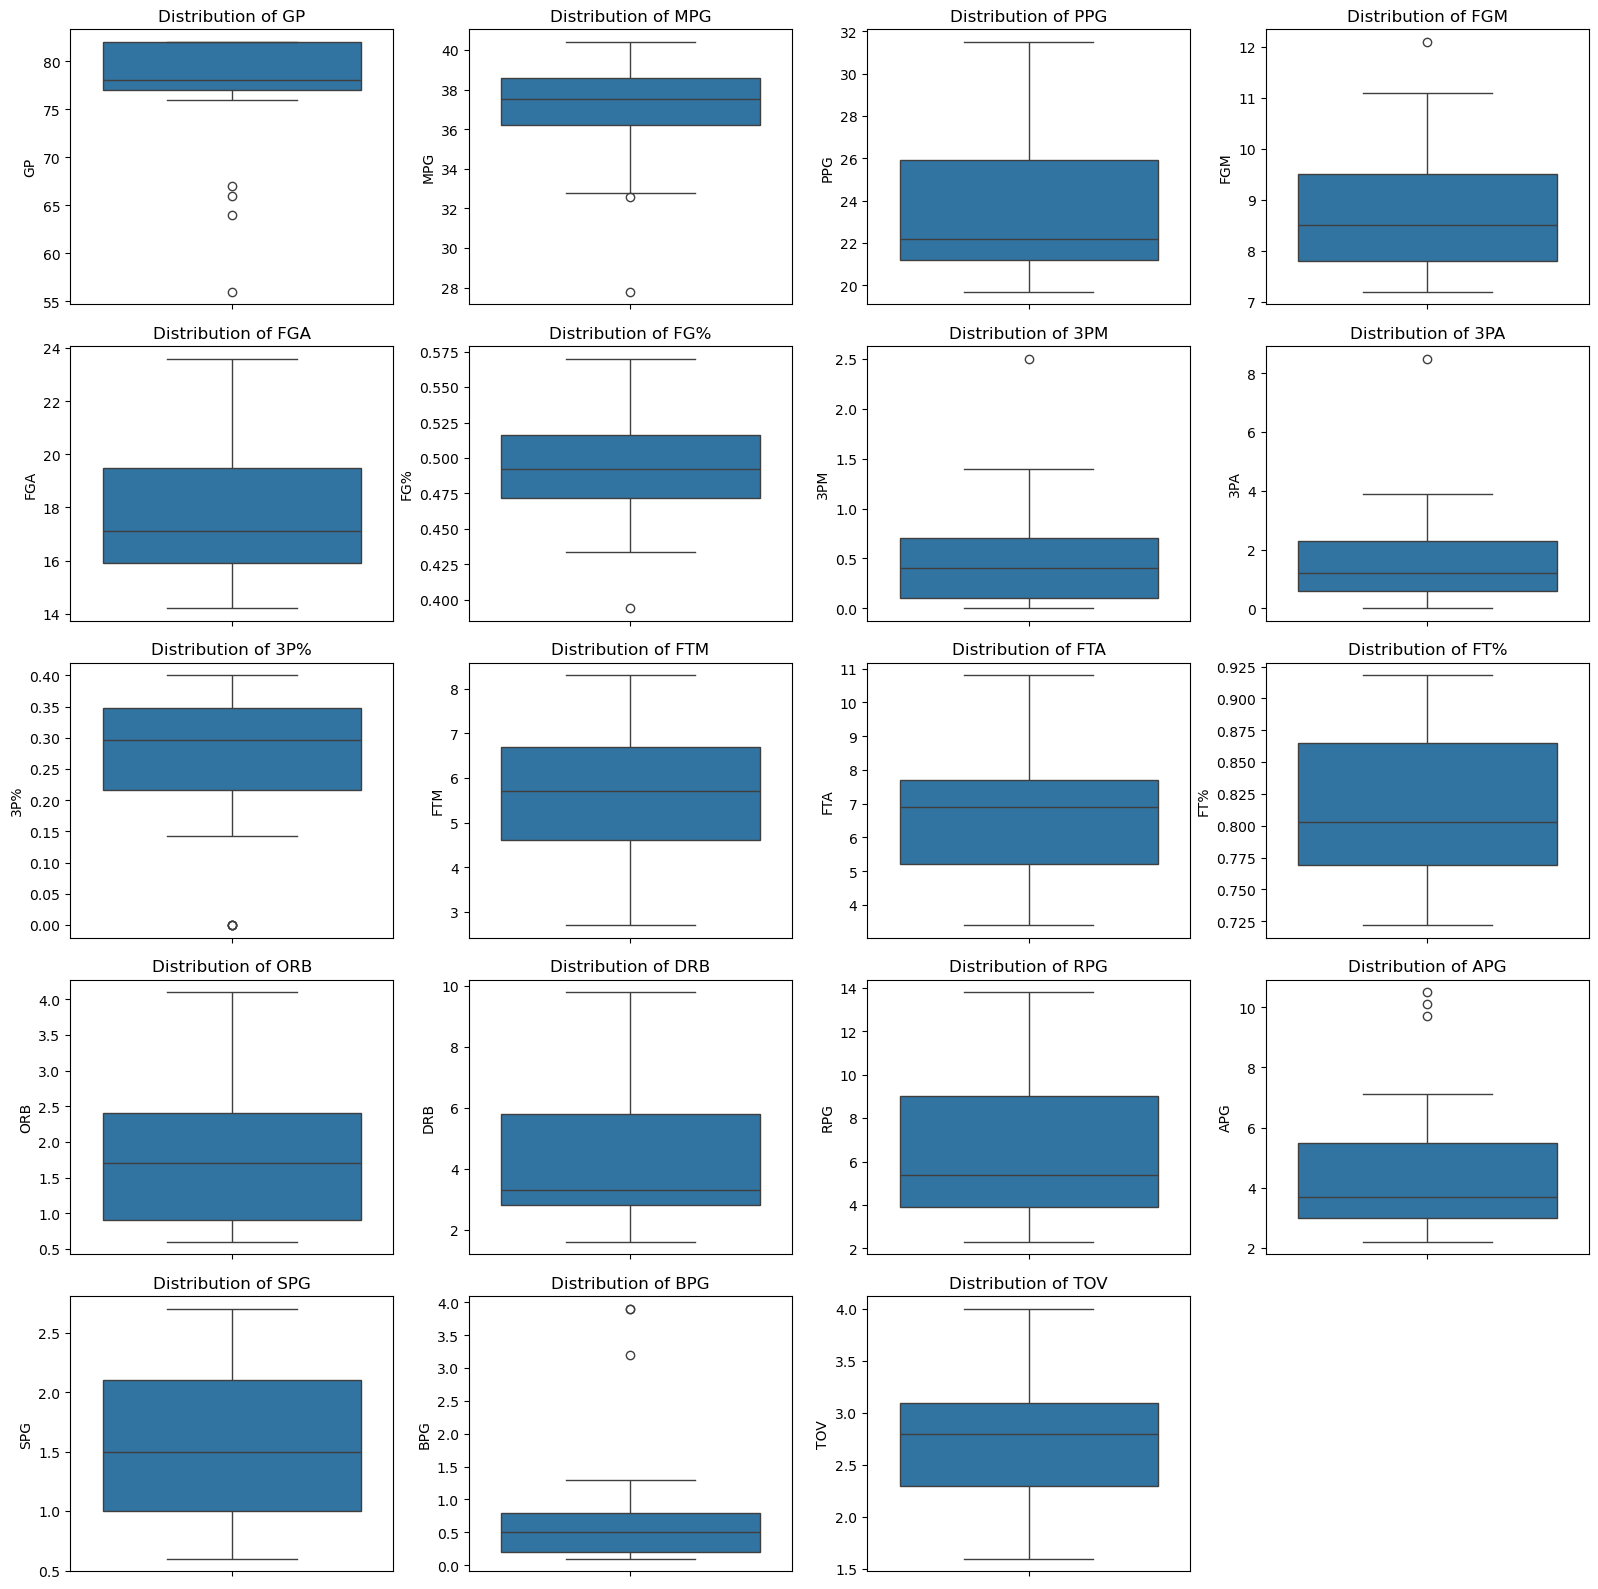

In [58]:
check_distributions(top_25_scorers, interested_columns, "boxenplot")

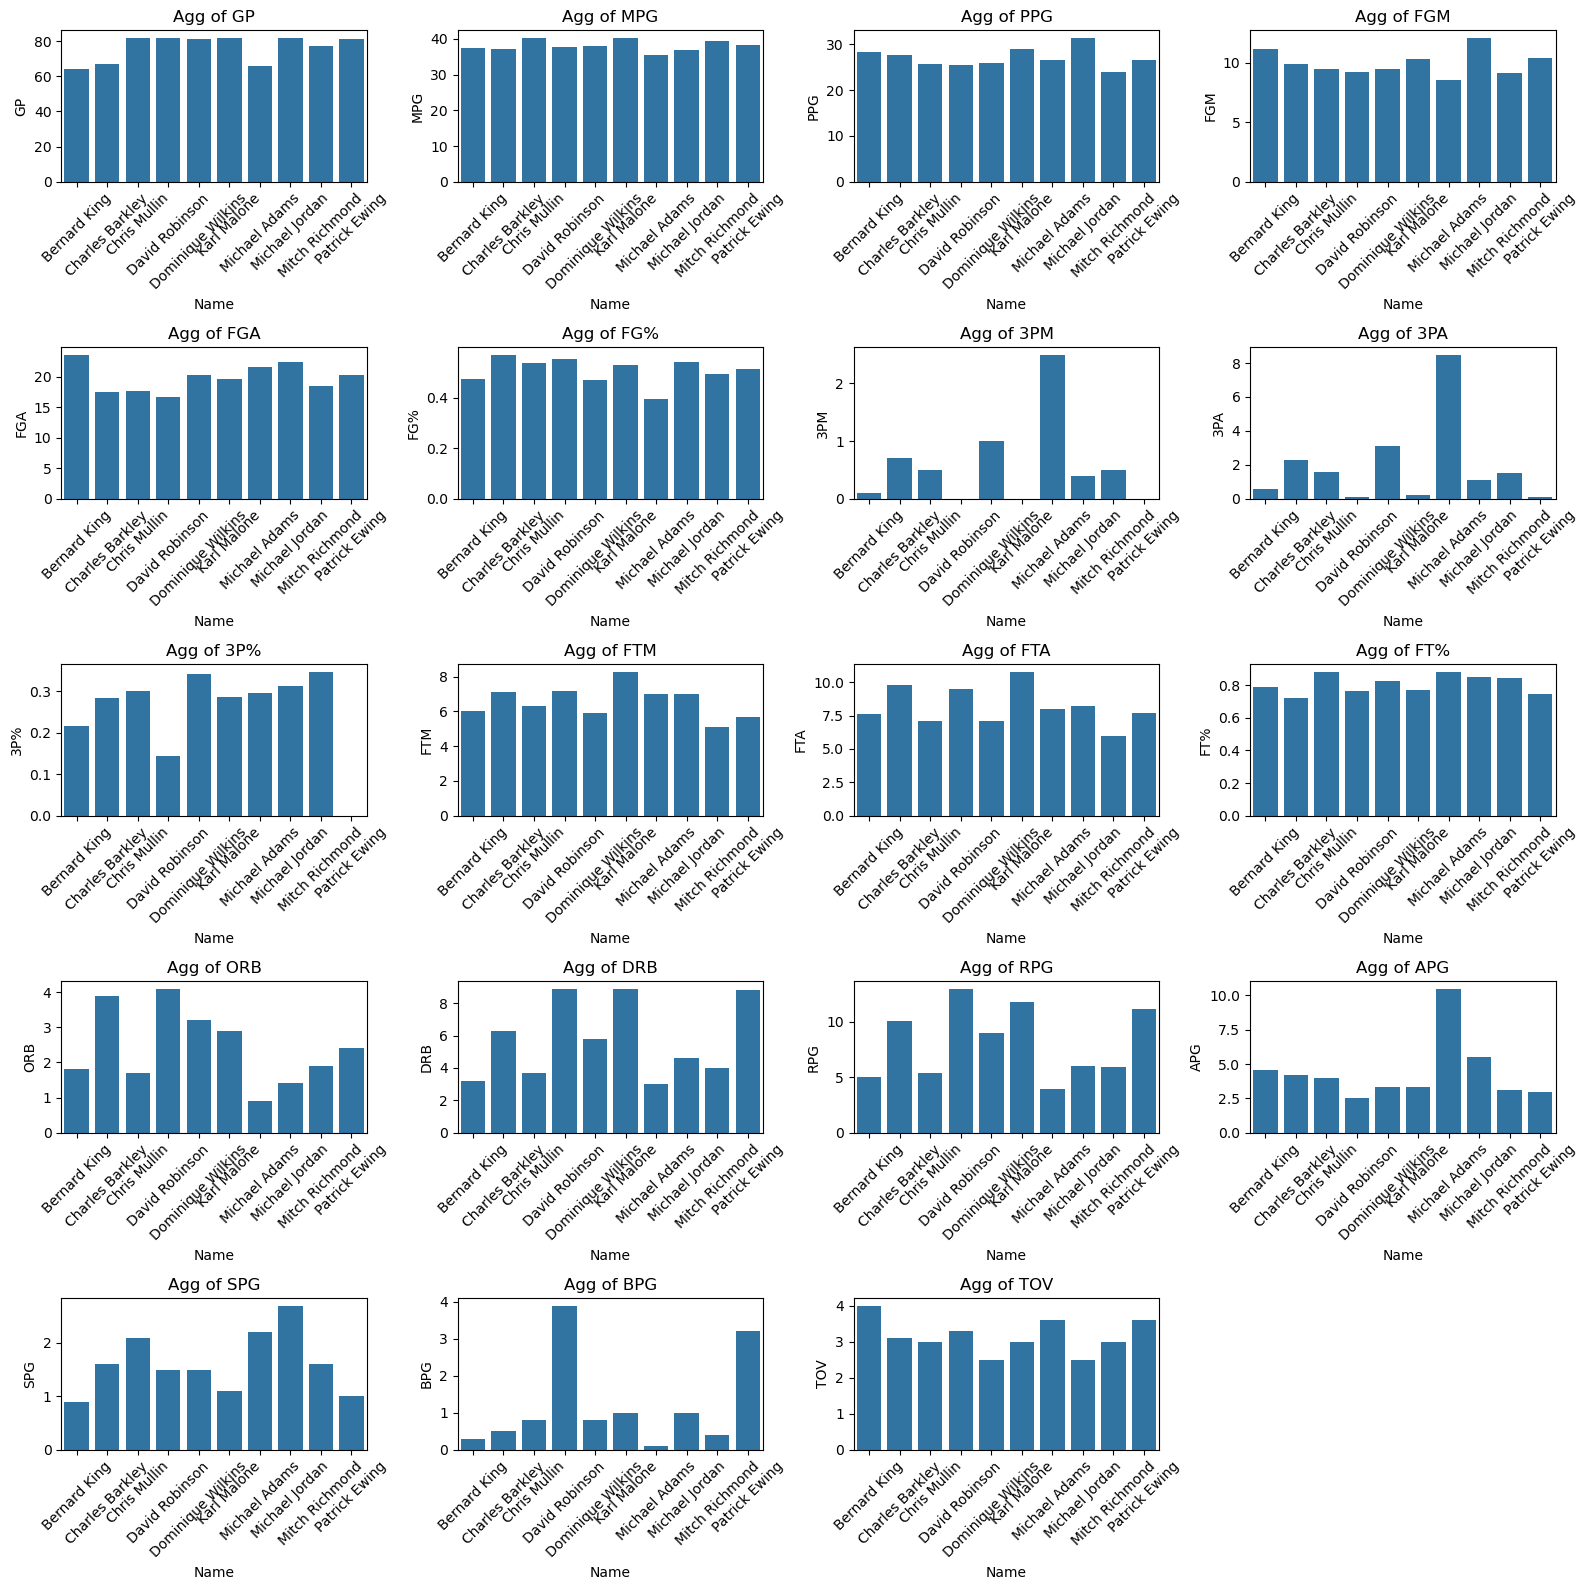

In [61]:
aggregate_dataset(top_25_scorers, interested_columns, "Name", "sum")

# Top 10 Rebounders

In [64]:
top_10_rebounders = df.sort_values(by="RPG",ascending=False).reset_index().head(10)
top_10_rebounders

,index,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,18,3175000.0,Hakeem Olajuwon,HOU,56,36.8,21.2,8.7,17.1,0.508,...,4.9,0.769,3.9,9.8,13.8,2.3,2.2,3.9,3.1,1990-1991
1,8,2265000.0,David Robinson,SAS,82,37.7,25.6,9.2,16.7,0.552,...,9.5,0.762,4.1,8.9,13.0,2.5,1.5,3.9,3.3,1990-1991
2,150,880000.0,Dennis Rodman,DET,82,33.5,8.2,3.4,6.8,0.493,...,2.1,0.631,4.4,8.1,12.5,1.0,0.8,0.7,1.1,1990-1991
3,111,1050000.0,Charles Oakley,NYK,76,36.0,11.2,4.0,7.8,0.516,...,4.0,0.784,4.0,8.1,12.1,2.7,0.8,0.2,2.8,1990-1991
4,1,2260000.0,Karl Malone,UTA,82,40.3,29.0,10.3,19.6,0.527,...,10.8,0.770,2.9,8.9,11.8,3.3,1.1,1.0,3.0,1990-1991
5,4,4250000.0,Patrick Ewing,NYK,81,38.3,26.6,10.4,20.3,0.514,...,7.7,0.745,2.4,8.8,11.2,3.0,1.0,3.2,3.6,1990-1991
6,54,755000.0,Rony Seikaly,MIA,64,33.9,16.4,6.2,12.8,0.481,...,6.5,0.619,3.2,7.8,11.1,1.5,0.8,1.3,3.2,1990-1991
7,15,1320000.0,Brad Daugherty,CLE,76,38.8,21.6,8.0,15.2,0.524,...,7.6,0.751,2.3,8.6,10.9,3.3,1.0,0.6,2.8,1990-1991
8,68,2500000.0,Robert Parish,BOS,81,30.1,14.9,6.0,10.0,0.598,...,3.8,0.767,3.3,7.2,10.6,0.8,0.8,1.3,1.9,1990-1991
9,41,1760000.0,Otis Thorpe,HOU,82,37.1,17.5,6.7,12.0,0.556,...,5.9,0.696,3.5,6.8,10.3,2.4,0.9,0.2,2.6,1990-1991


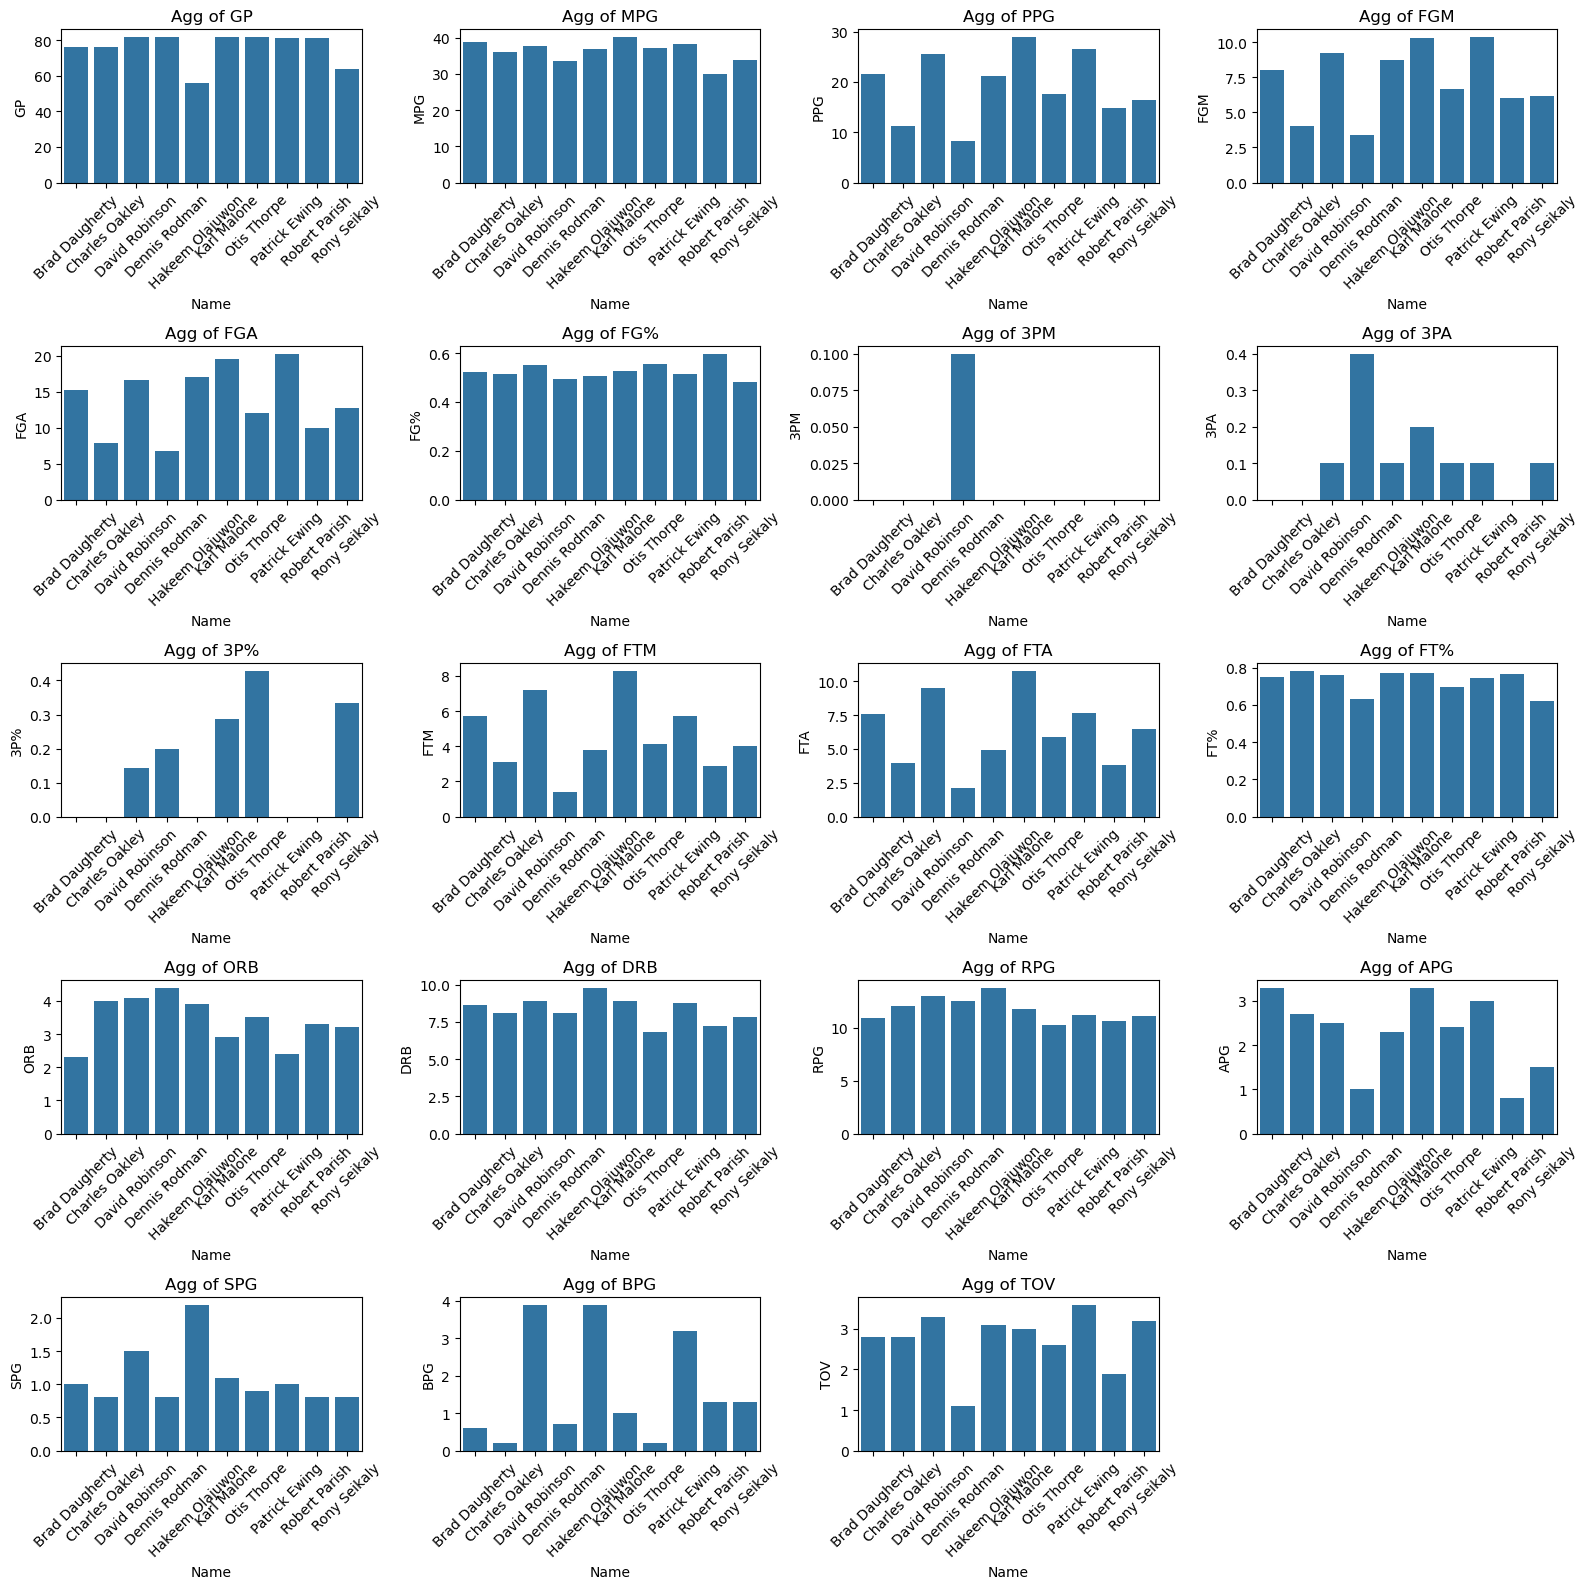

In [65]:
aggregate_dataset(top_10_rebounders, interested_columns, "Name", "sum")

# Top 10 Offensive Rebounds

In [66]:
top_10_ORB = df.sort_values(by="ORB",ascending=False).reset_index().head(10)
top_10_ORB

,index,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,158,500000.0,Jerome Lane,DEN,62,22.3,7.5,3.3,7.4,0.438,...,2.3,0.411,4.5,4.8,9.3,2.0,0.8,0.2,1.7,1990-1991
1,150,880000.0,Dennis Rodman,DET,82,33.5,8.2,3.4,6.8,0.493,...,2.1,0.631,4.4,8.1,12.5,1.0,0.8,0.7,1.1,1990-1991
2,8,2265000.0,David Robinson,SAS,82,37.7,25.6,9.2,16.7,0.552,...,9.5,0.762,4.1,8.9,13.0,2.5,1.5,3.9,3.3,1990-1991
3,111,1050000.0,Charles Oakley,NYK,76,36.0,11.2,4.0,7.8,0.516,...,4.0,0.784,4.0,8.1,12.1,2.7,0.8,0.2,2.8,1990-1991
4,18,3175000.0,Hakeem Olajuwon,HOU,56,36.8,21.2,8.7,17.1,0.508,...,4.9,0.769,3.9,9.8,13.8,2.3,2.2,3.9,3.1,1990-1991
5,3,2900000.0,Charles Barkley,PHI,67,37.3,27.6,9.9,17.4,0.570,...,9.8,0.722,3.9,6.3,10.1,4.2,1.6,0.5,3.1,1990-1991
6,164,950000.0,Chris Dudley,NJN,61,25.6,7.1,2.8,6.8,0.408,...,2.9,0.534,3.8,4.6,8.4,0.6,0.6,2.5,1.3,1990-1991
7,234,800000.0,Larry Smith,HOU,81,23.7,3.3,1.6,3.2,0.487,...,0.6,0.240,3.7,5.0,8.8,1.1,1.0,0.3,1.1,1990-1991
8,32,2100000.0,Derrick Coleman,NJN,74,35.2,18.4,6.9,14.9,0.467,...,6.0,0.731,3.6,6.6,10.3,2.2,1.0,1.3,2.9,1990-1991
9,41,1760000.0,Otis Thorpe,HOU,82,37.1,17.5,6.7,12.0,0.556,...,5.9,0.696,3.5,6.8,10.3,2.4,0.9,0.2,2.6,1990-1991


# Top 10 FG %

In [68]:
top_10_FG_PER= df.sort_values(by="FG%",ascending=False).reset_index().head(10)
top_10_FG_PER

,index,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,154,875000.0,Mark West,PHX,82,23.9,7.7,3.0,4.7,0.647,...,2.5,0.655,2.1,4.8,6.9,0.5,0.4,2.0,1.0,1990-1991
1,108,1550000.0,Buck Williams,POR,80,32.3,11.7,4.5,7.4,0.602,...,3.9,0.705,2.8,6.6,9.4,1.2,0.6,0.6,1.7,1990-1991
2,68,2500000.0,Robert Parish,BOS,81,30.1,14.9,6.0,10.0,0.598,...,3.8,0.767,3.3,7.2,10.6,0.8,0.8,1.3,1.9,1990-1991
3,63,375000.0,Kevin Gamble,BOS,82,33.0,15.6,6.7,11.4,0.587,...,2.8,0.815,1.0,2.2,3.3,3.1,1.2,0.4,1.8,1990-1991
4,200,2000000.0,Mark Eaton,UTA,80,32.3,5.1,2.1,3.7,0.579,...,1.4,0.634,2.3,6.1,8.3,0.6,0.5,2.4,1.2,1990-1991
5,202,600000.0,Andrew Lang,PHX,63,18.3,4.9,1.7,3.0,0.577,...,2.1,0.715,1.8,3.0,4.8,0.4,0.3,2.0,0.7,1990-1991
6,3,2900000.0,Charles Barkley,PHI,67,37.3,27.6,9.9,17.4,0.570,...,9.8,0.722,3.9,6.3,10.1,4.2,1.6,0.5,3.1,1990-1991
7,110,770000.0,Vlade Divac,LAL,82,28.2,11.2,4.4,7.8,0.565,...,3.4,0.703,2.5,5.6,8.1,1.1,1.3,1.5,1.8,1990-1991
8,131,600000.0,Olden Polynice,LAC,79,26.5,9.8,4.0,7.1,0.560,...,3.2,0.579,2.8,4.2,7.0,0.5,0.5,0.4,1.1,1990-1991
9,41,1760000.0,Otis Thorpe,HOU,82,37.1,17.5,6.7,12.0,0.556,...,5.9,0.696,3.5,6.8,10.3,2.4,0.9,0.2,2.6,1990-1991


# Top 10 Assits Per Game

In [69]:
top_10_APG= df.sort_values(by="APG",ascending=False).reset_index().head(10)
top_10_APG

,index,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,44,2000000.0,John Stockton,UTA,82,37.8,17.2,6.0,11.9,0.507,...,5.3,0.836,0.6,2.3,2.9,14.2,2.9,0.2,3.6,1990-1991
1,26,2400000.0,Magic Johnson,LAL,79,37.1,19.4,5.9,12.4,0.477,...,7.3,0.906,1.3,5.6,7.0,12.5,1.3,0.2,4.0,1990-1991
2,5,825000.0,Michael Adams,DEN,66,35.5,26.5,8.5,21.5,0.394,...,8.0,0.879,0.9,3.0,3.9,10.5,2.2,0.1,3.6,1990-1991
3,12,1750000.0,Kevin Johnson,PHX,77,36.0,22.2,7.7,14.9,0.516,...,8.0,0.843,0.7,2.8,3.5,10.1,2.1,0.1,3.5,1990-1991
4,10,500000.0,Tim Hardaway,GSW,82,39.2,22.9,9.0,18.9,0.476,...,4.6,0.803,1.1,3.0,4.0,9.7,2.6,0.1,3.3,1990-1991
5,56,2720000.0,Isiah Thomas,DET,48,34.5,16.2,6.0,13.9,0.435,...,4.8,0.782,0.7,2.6,3.3,9.3,1.6,0.2,3.9,1990-1991
6,46,615000.0,Pooh Richardson,MIN,82,38.5,17.1,7.7,16.5,0.470,...,2.0,0.539,1.0,2.5,3.5,9.0,1.6,0.2,2.1,1990-1991
7,143,530000.0,Gary Grant,LAC,68,31.0,8.7,3.9,8.6,0.451,...,1.1,0.689,1.0,2.1,3.1,8.6,1.5,0.2,3.1,1990-1991
8,31,325000.0,Sherman Douglas,MIA,73,35.1,18.5,7.3,14.5,0.504,...,5.7,0.686,1.1,1.8,2.9,8.5,1.7,0.1,3.7,1990-1991
9,45,408000.0,Scott Skiles,ORL,79,34.4,17.2,5.8,13.2,0.445,...,4.8,0.902,0.7,2.7,3.4,8.4,1.1,0.1,3.2,1990-1991


# Top 10 Blocks Per Game

In [70]:
top_10_BPG= df.sort_values(by="BPG",ascending=False).reset_index().head(10)
top_10_BPG

,index,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,18,3175000.0,Hakeem Olajuwon,HOU,56,36.8,21.2,8.7,17.1,0.508,...,4.9,0.769,3.9,9.8,13.8,2.3,2.2,3.9,3.1,1990-1991
1,8,2265000.0,David Robinson,SAS,82,37.7,25.6,9.2,16.7,0.552,...,9.5,0.762,4.1,8.9,13.0,2.5,1.5,3.9,3.3,1990-1991
2,4,4250000.0,Patrick Ewing,NYK,81,38.3,26.6,10.4,20.3,0.514,...,7.7,0.745,2.4,8.8,11.2,3.0,1.0,3.2,3.6,1990-1991
3,242,1300000.0,Manute Bol,PHI,82,18.6,1.9,0.8,2.0,0.396,...,0.5,0.585,0.8,3.5,4.3,0.2,0.2,3.0,0.8,1990-1991
4,164,950000.0,Chris Dudley,NJN,61,25.6,7.1,2.8,6.8,0.408,...,2.9,0.534,3.8,4.6,8.4,0.6,0.6,2.5,1.3,1990-1991
5,27,1260000.0,Larry Nance,CLE,80,36.6,19.2,7.9,15.1,0.524,...,4.1,0.803,2.5,6.1,8.6,3.0,0.8,2.5,1.6,1990-1991
6,200,2000000.0,Mark Eaton,UTA,80,32.3,5.1,2.1,3.7,0.579,...,1.4,0.634,2.3,6.1,8.3,0.6,0.5,2.4,1.2,1990-1991
7,78,1750000.0,Benoit Benjamin,SEA,70,31.9,14.0,5.5,11.1,0.496,...,4.2,0.712,2.2,8.1,10.3,1.7,0.8,2.1,3.4,1990-1991
8,124,2300000.0,Pervis Ellison,WAS,76,25.6,10.4,4.3,8.4,0.513,...,2.8,0.650,2.9,4.8,7.7,1.3,0.6,2.1,1.9,1990-1991
9,34,1400000.0,Kevin McHale,BOS,68,30.4,18.4,7.4,13.4,0.553,...,4.0,0.829,2.1,4.9,7.1,1.9,0.4,2.1,2.1,1990-1991


# Top 10 Field Goals Made

In [71]:
top_10_FGM= df.sort_values(by="FGM",ascending=False).reset_index().head(10)
top_10_FGM

,index,salary,Name,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,season
0,0,2500000.0,Michael Jordan,CHI,82,37.0,31.5,12.1,22.4,0.539,...,8.2,0.851,1.4,4.6,6.0,5.5,2.7,1.0,2.5,1990-1991
1,2,1600000.0,Bernard King,WAS,64,37.5,28.4,11.1,23.6,0.472,...,7.6,0.790,1.8,3.2,5.0,4.6,0.9,0.3,4.0,1990-1991
2,4,4250000.0,Patrick Ewing,NYK,81,38.3,26.6,10.4,20.3,0.514,...,7.7,0.745,2.4,8.8,11.2,3.0,1.0,3.2,3.6,1990-1991
3,1,2260000.0,Karl Malone,UTA,82,40.3,29.0,10.3,19.6,0.527,...,10.8,0.770,2.9,8.9,11.8,3.3,1.1,1.0,3.0,1990-1991
4,3,2900000.0,Charles Barkley,PHI,67,37.3,27.6,9.9,17.4,0.570,...,9.8,0.722,3.9,6.3,10.1,4.2,1.6,0.5,3.1,1990-1991
5,6,2065000.0,Dominique Wilkins,ATL,81,38.0,25.9,9.5,20.2,0.470,...,7.1,0.829,3.2,5.8,9.0,3.3,1.5,0.8,2.5,1990-1991
6,7,2850000.0,Chris Mullin,GSW,82,40.4,25.7,9.5,17.7,0.536,...,7.1,0.884,1.7,3.7,5.4,4.0,2.1,0.8,3.0,1990-1991
7,8,2265000.0,David Robinson,SAS,82,37.7,25.6,9.2,16.7,0.552,...,9.5,0.762,4.1,8.9,13.0,2.5,1.5,3.9,3.3,1990-1991
8,17,1600000.0,James Worthy,LAL,78,38.6,21.4,9.2,18.7,0.492,...,3.4,0.797,1.4,3.2,4.6,3.5,1.3,0.4,1.6,1990-1991
9,9,850000.0,Mitch Richmond,GSW,77,39.3,23.9,9.1,18.5,0.494,...,6.0,0.847,1.9,4.0,5.9,3.1,1.6,0.4,3.0,1990-1991


# Baseline Model

In [75]:
X =df.drop(["Name", "Team", "salary", "season"], axis=1)
y = df["salary"]

# PCA Analysis

In [80]:
pca_analysis(X)

,Component,CumSum
0,1,0.454533
1,2,0.709408
2,3,0.767488
3,4,0.818065
4,5,0.864077
5,6,0.898874
6,7,0.922120
7,8,0.940812
8,9,0.957608
9,10,0.973881


# Create Metrics

In [82]:
MAE = make_scorer(score_func=mean_absolute_error, greater_is_better =False)
MSE = make_scorer(score_func=mean_squared_error, greater_is_better=False)
R2 = make_scorer(score_func=r2_score, greater_is_better=True)
EXP_VAR = make_scorer(score_func=explained_variance_score, greater_is_better=True)

In [84]:
model_names = ["DUMMY"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, MAE)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,DUMMY,-507274.83,6.474723e+09,80465.664,522105.403,4.653147e+11,682139.809,-0.061,-0.061


# Baseline Model Performs awful

# Select KBest Models

In [89]:
model_names = ["LR"]
models = grab_selected_models(model_names)
kbest = mutual_info_regression
test_kbest_columns(X, y, models[0], model_names[0], kbest)

,Model,K,MAE,MSE,RMSE,R2,Explained Var
0,LR,1,471978.626662,3.418085e+11,584643.899470,0.167651,0.170207
1,LR,2,476741.904792,3.455947e+11,587873.002073,0.158431,0.159623
2,LR,3,471965.311074,3.334443e+11,577446.342626,0.188019,0.190803
3,LR,4,469305.976992,3.408524e+11,583825.652645,0.169979,0.171185
4,LR,5,467221.826123,3.337754e+11,577732.963807,0.187213,0.189260
5,LR,6,462460.437669,3.255192e+11,570542.892436,0.207317,0.210626
6,LR,7,446222.693000,2.992758e+11,547061.034759,0.271224,0.272942
7,LR,8,456124.862892,3.158193e+11,561978.002127,0.230938,0.232159
8,LR,9,453492.011960,3.167011e+11,562761.993416,0.228791,0.231150
9,LR,10,453381.249292,3.171300e+11,563142.936791,0.227746,0.230134


# Horrific results

In [90]:
model_names = ["LR"]
models = grab_selected_models(model_names)
kbest = f_regression
test_kbest_columns(X, y, models[0], model_names[0], kbest)

,Model,K,MAE,MSE,RMSE,R2,Explained Var
0,LR,1,471987.175065,3.392677e+11,582466.901399,0.173838,0.175854
1,LR,2,476741.904792,3.455947e+11,587873.002073,0.158431,0.159623
2,LR,3,466071.976360,3.305682e+11,574950.597921,0.195022,0.195524
3,LR,4,467124.884854,3.349087e+11,578712.979259,0.184453,0.185306
4,LR,5,452054.960900,3.156885e+11,561861.652313,0.231256,0.231904
5,LR,6,451640.414884,3.163970e+11,562491.777552,0.229531,0.230270
6,LR,7,449345.624540,3.134795e+11,559892.372763,0.236636,0.237951
7,LR,8,446429.967410,3.059035e+11,553085.427924,0.255084,0.258010
8,LR,9,447144.627820,3.052160e+11,552463.537923,0.256759,0.259932
9,LR,10,453381.249292,3.171300e+11,563142.936791,0.227746,0.230134


In [91]:
model_names = ["LR", "SVR", "KNN"]
models = grab_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_regression, k=7)
test_selected_models(model_names, models, X, y, MAE, kbest)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,LR,-423062.815,3.866914e+09,62184.518,427055.250,3.005773e+11,548249.261,0.315,0.316
2,KNN,-451908.110,5.481085e+09,74034.347,458213.992,3.611833e+11,600985.236,0.177,0.177
1,SVR,-490907.093,7.909329e+09,88934.406,501788.622,4.813243e+11,693775.420,-0.097,-0.049


In [92]:
model_names = ["DTR", "RFR", "XGB", "GBR"]
models = grab_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_regression, k=7)
test_selected_models(model_names, models, X, y, MAE, kbest)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
1,RFR,-455018.839,5.190941e+09,72048.185,458991.152,3.435717e+11,586149.923,0.217,0.217
3,GBR,-469962.736,6.234444e+09,78958.495,485165.493,3.975205e+11,630492.287,0.094,0.094
2,XGB,-499923.797,8.106005e+09,90033.354,499416.971,4.491750e+11,670205.212,-0.024,-0.019
0,DTR,-605279.017,8.848189e+09,94064.814,606074.074,5.924701e+11,769720.803,-0.351,-0.349


In [93]:
params = {
  'RIDGE': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'LASSO': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 5000, 10000]
    },
  
    'DTR': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'RFR': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'GBR': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 4, 6],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 10, 15],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [10, 30, 50],
        'model__p': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
        'model__reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'model__reg_lambda': [1, 1.5, 2.0]  # L2 regularization term on weights
    }
}

In [97]:
model_names = ["LASSO","RIDGE", "SVR", "KNN"]
models = grab_selected_models(model_names)
optimization_search(model_names, models, X, y, RandomizedSearchCV, params, MAE, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.935e+10, tolerance: 6.397e+09
  model = cd_fast.enet_coordinate_descent(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.707e+10, tolerance: 6.915e+09
  model = cd_fast.enet_coordinate_descent(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number o

The Best Param: {'model__max_iter': 5000, 'model__alpha': 100} for Model: LASSO
The Best Param: {'model__solver': 'svd', 'model__alpha': 1} for Model: RIDGE
The Best Param: {'model__kernel': 'linear', 'model__gamma': 'scale', 'model__C': 10} for Model: SVR
The Best Param: {'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 15, 'model__leaf_size': 10, 'model__algorithm': 'ball_tree'} for Model: KNN


,Model,MAE,MSE,RMSE,R2,Explained Var
1,RIDGE,445500.485113,2.970570e+11,545029.359731,0.276627,0.278305
0,LASSO,446201.773657,2.991346e+11,546931.960658,0.271568,0.273277
3,KNN,461256.681446,3.284143e+11,573074.443595,0.200267,0.200306
2,SVR,483419.762923,4.331865e+11,658169.027669,-0.054867,0.004693


# Model Cannot predict Salary with any confidence

In [98]:
X =df.drop(["Name", "Team", "PPG", "season"], axis=1)
y = df["PPG"]

In [99]:
model_names = ["DUMMY"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, MAE)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,DUMMY,-5.215,0.53,0.728,5.762,47.726,6.908,-0.229,-0.229


In [100]:
model_names = ["LR"]
models = grab_selected_models(model_names)
kbest = mutual_info_regression
test_kbest_columns(X, y, models[0], model_names[0], kbest)

,Model,K,MAE,MSE,RMSE,R2,Explained Var
0,LR,1,1.122144,1.943312,1.394027,0.945122,0.945124
1,LR,2,1.152055,2.058334,1.434690,0.941874,0.941874
2,LR,3,1.154196,2.066159,1.437414,0.941653,0.941653
3,LR,4,1.014653,1.539704,1.240848,0.956519,0.956752
4,LR,5,1.014802,1.540074,1.240997,0.956509,0.956741
5,LR,6,1.016812,1.547452,1.243966,0.956301,0.956456
6,LR,7,1.023908,1.568386,1.252352,0.955709,0.956024
7,LR,8,1.024824,1.571807,1.253717,0.955613,0.955966
8,LR,9,1.034410,1.584740,1.258865,0.955248,0.955751
9,LR,10,1.050477,1.728645,1.314779,0.951184,0.951568
